In [22]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

### Download data from AWS RDS to DataFrame

In [23]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [24]:
# upload additional tables

property_type_df_file = os.path.join('data_prep', 'property_type_df.csv')
pd.read_csv(property_type_df_file).to_sql(name='property_type_crime', con=engine, if_exists='replace')

violent_type_df_file = os.path.join('data_prep', 'violent_type_df.csv')
pd.read_csv(violent_type_df_file).to_sql(name='violent_type_crime', con=engine, if_exists='replace')

In [25]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

['offense_cat_offender_race_2020',
 'offense_cat_offender_sex_2020',
 'offense_cat_type_2020',
 'offense_cat_victim_age_2020',
 'offense_cat_victim_race_2020',
 'offense_cat_victim_sex_2020',
 'state_pop_agencies_2020',
 'gpd_by_state_2020',
 'state_size',
 'property_type_crime',
 'violent_type_crime',
 'offense_cat_loc_2020',
 'offense_cat_state_2020',
 'law_enforcement_state_2020',
 'law_enforcement_state_city_2020',
 'offense_cat_offender_age_2020']

In [26]:
with engine.connect() as conn:
    violent_crime_df = pd.read_sql("SELECT * FROM violent_type_crime", conn)
    property_crime_df = pd.read_sql("SELECT * FROM property_type_crime", conn)

property_crime_df.drop(['index'], axis=1, inplace=True)
property_crime_df.set_index('FIPS', inplace=True)

violent_crime_df.drop('index', axis=1, inplace=True)
violent_crime_df.set_index('FIPS', inplace=True)

print(property_crime_df.shape)
print(violent_crime_df.shape)

(2071, 15)
(2000, 15)


In [27]:
violent_crime_df.head()

crimes  total_law_emp  officers  civilians  \
FIPS                                                 
1001.0    55.0             69        31         38   
1003.0   163.0            296       111        185   
1007.0     3.0             10         9          1   
1015.0    18.0             56        51          5   
1033.0    58.0             53        34         19   

        percent_edu_less_than_high_school  percent_edu_high_school  \
FIPS                                                                 
1001.0                          11.483395                33.588459   
1003.0                           9.193843                27.659616   
1007.0                          20.942602                44.878773   
1015.0                          15.567326                32.790615   
1033.0                          14.843810                37.834648   

        percent_edu_some_college  percent_edu_bachelor_or_higher  \
FIPS                                                               
1001.0                 28.356571                       26.571573   
1003.0                 31.284081                       31.862459   
1007.0                 23.800098                       10.378526   
1015.0                 33.160995                       18.481064   
1033.0                 29.174259                       18.147284   

        unemployment_rate  median_HH_Income  population  \
FIPS                                                      
1001.0                4.0           58233.0       55200   
1003.0                4.2           59871.0      208107   
1007.0                4.5           47918.0       22527   
1015.0                5.1           47747.0      115098   
1033.0                5.4           46683.0       54495   

        pop_dens_ppl_per_sqkm  percent_poverty_all_age  \
FIPS                                                     
1001.0              35.853419                     12.1   
1003.0              50.541504                     10.1   
1007.0              13.973114                     20.3   
1015.0              73.348688                     17.2   
1033.0              35.496950                     14.6   

        percent_poverty_age_0-17  percent_poverty_age_5-17  
FIPS                                                        
1001.0                      15.9                      14.4  
1003.0                      13.5                      13.3  
1007.0                      25.9                      25.2  
1015.0                      24.6                      22.8  
1033.0                      19.4                      18.6

In [28]:
property_crime_df.head()

crimes  total_law_emp  officers  civilians  \
FIPS                                                 
1001.0   384.0             69        31         38   
1003.0   737.0            296       111        185   
1007.0    69.0             10         9          1   
1015.0   211.0             56        51          5   
1033.0   267.0             53        34         19   

        percent_edu_less_than_high_school  percent_edu_high_school  \
FIPS                                                                 
1001.0                          11.483395                33.588459   
1003.0                           9.193843                27.659616   
1007.0                          20.942602                44.878773   
1015.0                          15.567326                32.790615   
1033.0                          14.843810                37.834648   

        percent_edu_some_college  percent_edu_bachelor_or_higher  \
FIPS                                                               
1001.0                 28.356571                       26.571573   
1003.0                 31.284081                       31.862459   
1007.0                 23.800098                       10.378526   
1015.0                 33.160995                       18.481064   
1033.0                 29.174259                       18.147284   

        unemployment_rate  median_HH_Income  population  \
FIPS                                                      
1001.0                4.0           58233.0       55200   
1003.0                4.2           59871.0      208107   
1007.0                4.5           47918.0       22527   
1015.0                5.1           47747.0      115098   
1033.0                5.4           46683.0       54495   

        pop_dens_ppl_per_sqkm  percent_poverty_all_age  \
FIPS                                                     
1001.0              35.853419                     12.1   
1003.0              50.541504                     10.1   
1007.0              13.973114                     20.3   
1015.0              73.348688                     17.2   
1033.0              35.496950                     14.6   

        percent_poverty_age_0-17  percent_poverty_age_5-17  
FIPS                                                        
1001.0                      15.9                      14.4  
1003.0                      13.5                      13.3  
1007.0                      25.9                      25.2  
1015.0                      24.6                      22.8  
1033.0                      19.4                      18.6

### Analyse violent crimes

#### examine the dataset

In [29]:
# change index to default

original_df = violent_crime_df.copy()
original_df.reset_index(drop=True, inplace=True)
original_df

crimes  total_law_emp  officers  civilians  \
0       55.0             69        31         38   
1      163.0            296       111        185   
2        3.0             10         9          1   
3       18.0             56        51          5   
4       58.0             53        34         19   
...      ...            ...       ...        ...   
1995    10.0             71        35         36   
1996    23.0             95        39         56   
1997     2.0             47        34         13   
1998     4.0              9         8          1   
1999     2.0              8         8          0   

      percent_edu_less_than_high_school  percent_edu_high_school  \
0                             11.483395                33.588459   
1                              9.193843                27.659616   
2                             20.942602                44.878773   
3                             15.567326                32.790615   
4                             14.843810                37.834648   
...                                 ...                      ...   
1995                           4.009988                34.635723   
1996                           7.213361                33.041271   
1997                           7.258562                41.522678   
1998                          10.241615                29.751171   
1999                           6.349518                37.428741   

      percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                    28.356571                       26.571573   
1                    31.284081                       31.862459   
2                    23.800098                       10.378526   
3                    33.160995                       18.481064   
4                    29.174259                       18.147284   
...                        ...                             ...   
1995                 38.572269                       22.782021   
1996                 37.246979                       22.498390   
1997                 35.189754                       16.029003   
1998                 36.620987                       23.386225   
1999                 36.249264                       19.972479   

      unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0                   4.0           58233.0       55200              35.853419   
1                   4.2           59871.0      208107              50.541504   
2                   4.5           47918.0       22527              13.973114   
3                   5.1           47747.0      115098              73.348688   
4                   5.4           46683.0       54495              35.496950   
...                 ...               ...         ...                    ...   
1995                4.6           78055.0        9951               0.786272   
1996                4.7           80639.0       44117               1.633615   
1997                4.7           70756.0       20609               3.822405   
1998                4.1           55122.0        8129               1.402002   
1999                4.1           59410.0        7100               1.143169   

      percent_poverty_all_age  percent_poverty_age_0-17  \
0                        12.1                      15.9   
1                        10.1                      13.5   
2                        20.3                      25.9   
3                        17.2                      24.6   
4                        14.6                      19.4   
...                       ...                       ...   
1995                      7.2                       8.2   
1996                      8.3                      10.1   
1997                      8.5                       9.6   
1998                     11.1                      13.9   
1999                     10.5                      13.8   

      percent_poverty_age_5-17  
0                         14.4  
1                         13.3  
2 

In [30]:
print(original_df['crimes'].value_counts())
print(original_df['civilians'].value_counts())

0.0       130
1.0       109
2.0        86
3.0        76
4.0        74
         ... 
163.0       1
1484.0      1
881.0       1
5957.0      1
154.0       1
Name: crimes, Length: 299, dtype: int64
1       108
2       103
3        83
0        80
5        75
       ... 
2078      1
188       1
323       1
292       1
173       1
Name: civilians, Length: 248, dtype: int64


In [31]:
# filter crimes=0
zero_df = original_df[(original_df['crimes']==0) | (original_df['civilians']==0)]
zero_df

crimes  total_law_emp  officers  civilians  \
186      0.0              7         3          4   
198      0.0              4         4          0   
201      0.0             28        11         17   
204      0.0             18         8         10   
205      0.0              3         3          0   
...      ...            ...       ...        ...   
1949     3.0             20        20          0   
1959     0.0             11         9          2   
1966     1.0             26        26          0   
1974     0.0             74        36         38   
1999     2.0              8         8          0   

      percent_edu_less_than_high_school  percent_edu_high_school  \
186                           12.628337                28.131416   
198                           11.500000                33.107143   
201                            8.117731                31.521481   
204                           16.939325                30.544626   
205                            6.185567                25.773195   
...                                 ...                      ...   
1949                           5.466028                33.667248   
1959                           8.095781                42.569366   
1966                           9.857666                40.829605   
1974                           6.281127                29.981836   
1999                           6.349518                37.428741   

      percent_edu_some_college  percent_edu_bachelor_or_higher  \
186                  39.219711                       20.020535   
198                  31.571428                       23.821428   
201                  37.621647                       22.739141   
204                  30.420378                       22.095673   
205                  32.371136                       35.670105   
...                        ...                             ...   
1949                 40.853657                       20.013065   
1959                 31.394907                       17.939947   
1966                 30.280602                       19.032127   
1974                 34.657528                       29.079510   
1999                 36.249264                       19.972479   

      unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
186                 1.7           53577.0        1296               0.310083   
198                 1.5           53432.0        4318               2.423494   
201                 3.6           65960.0        6465               0.774968   
204                 4.1           37004.0        6468               0.788151   
205                 2.1           50524.0         544               0.542016   
...                 ...               ...         ...                    ...   
1949                6.2           48813.0        5715               2.910324   
1959                5.9           40300.0        4579               4.943763   
1966                3.0           51295.0       17539              11.553103   
1974                4.3           55576.0       21593               9.720213   
1999                4.1           59410.0        7100               1.143169   

      percent_poverty_all_age  percent_poverty_age_0-17  \
186                      12.6                      18.5   
198                      10.4                      14.8   
201                      10.3                      12.8   
204                      25.4                      38.8   
205                      13.7                      19.3   
...                       ...                       ...   
1949                     12.7                      20.8   
1959                     25.3                      44.0   
1966                     12.5                      18.5   
1974                     11.2                      19.0   
1999                     10.5                      13.8   

      percent_poverty_age_5-17  
186                       18.3  
198                       14.2  
20

In [32]:
# remove rows of 0 crimes and 0 civilians

clean_df = original_df[(original_df['crimes']>0) & (original_df['civilians']>0)]
clean_df.reset_index(drop=True, inplace=True)
clean_df

crimes  total_law_emp  officers  civilians  \
0       55.0             69        31         38   
1      163.0            296       111        185   
2        3.0             10         9          1   
3       18.0             56        51          5   
4       58.0             53        34         19   
...      ...            ...       ...        ...   
1804     6.0             57        20         37   
1805    10.0             71        35         36   
1806    23.0             95        39         56   
1807     2.0             47        34         13   
1808     4.0              9         8          1   

      percent_edu_less_than_high_school  percent_edu_high_school  \
0                             11.483395                33.588459   
1                              9.193843                27.659616   
2                             20.942602                44.878773   
3                             15.567326                32.790615   
4                             14.843810                37.834648   
...                                 ...                      ...   
1804                           4.672548                25.635998   
1805                           4.009988                34.635723   
1806                           7.213361                33.041271   
1807                           7.258562                41.522678   
1808                          10.241615                29.751171   

      percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                    28.356571                       26.571573   
1                    31.284081                       31.862459   
2                    23.800098                       10.378526   
3                    33.160995                       18.481064   
4                    29.174259                       18.147284   
...                        ...                             ...   
1804                 38.734070                       30.957382   
1805                 38.572269                       22.782021   
1806                 37.246979                       22.498390   
1807                 35.189754                       16.029003   
1808                 36.620987                       23.386225   

      unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0                   4.0           58233.0       55200              35.853419   
1                   4.2           59871.0      208107              50.541504   
2                   4.5           47918.0       22527              13.973114   
3                   5.1           47747.0      115098              73.348688   
4                   5.4           46683.0       54495              35.496950   
...                 ...               ...         ...                    ...   
1804                4.0           64030.0       30012               4.592168   
1805                4.6           78055.0        9951               0.786272   
1806                4.7           80639.0       44117               1.633615   
1807                4.7           70756.0       20609               3.822405   
1808                4.1           55122.0        8129               1.402002   

      percent_poverty_all_age  percent_poverty_age_0-17  \
0                        12.1                      15.9   
1                        10.1                      13.5   
2                        20.3                      25.9   
3                        17.2                      24.6   
4                        14.6                      19.4   
...                       ...                       ...   
1804                      8.5                      10.0   
1805                      7.2                       8.2   
1806                      8.3                      10.1   
1807                      8.5                       9.6   
1808                     11.1                      13.9   

      percent_poverty_age_5-17  
0                         14.4  
1                         13.3  
2 

#### normalize a few columns against population

In [33]:
# normalize columns against population

norm_df = clean_df.copy()

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians'    
]

for col in columns_to_normalize:
    norm_df[col] = clean_df[col] / clean_df['population']

norm_df.head()

crimes  total_law_emp  officers  civilians  \
0  0.000996       0.001250  0.000562   0.000688   
1  0.000783       0.001422  0.000533   0.000889   
2  0.000133       0.000444  0.000400   0.000044   
3  0.000156       0.000487  0.000443   0.000043   
4  0.001064       0.000973  0.000624   0.000349   

   percent_edu_less_than_high_school  percent_edu_high_school  \
0                          11.483395                33.588459   
1                           9.193843                27.659616   
2                          20.942602                44.878773   
3                          15.567326                32.790615   
4                          14.843810                37.834648   

   percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                 28.356571                       26.571573   
1                 31.284081                       31.862459   
2                 23.800098                       10.378526   
3                 33.160995                       18.481064   
4                 29.174259                       18.147284   

   unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0                4.0           58233.0       55200              35.853419   
1                4.2           59871.0      208107              50.541504   
2                4.5           47918.0       22527              13.973114   
3                5.1           47747.0      115098              73.348688   
4                5.4           46683.0       54495              35.496950   

   percent_poverty_all_age  percent_poverty_age_0-17  percent_poverty_age_5-17  
0                     12.1                      15.9                      14.4  
1                     10.1                      13.5                      13.3  
2                     20.3                      25.9                      25.2  
3                     17.2                      24.6                      22.8  
4                     14.6                      19.4                      18.6

### Check skewness

In [34]:
norm_df.skew()

crimes                                2.991272
total_law_emp                         3.240630
officers                              3.404885
civilians                             4.158764
percent_edu_less_than_high_school     1.067508
percent_edu_high_school              -0.403074
percent_edu_some_college             -0.008065
percent_edu_bachelor_or_higher        1.367854
unemployment_rate                     2.168104
median_HH_Income                      1.505033
population                           12.975657
pop_dens_ppl_per_sqkm                 7.709310
percent_poverty_all_age               0.933746
percent_poverty_age_0-17              0.639058
percent_poverty_age_5-17              0.695144
dtype: float64

In [35]:
skewed_columns = ['crimes',
                  'total_law_emp',
                  'officers',
                  'civilians',
                  'population',
                  'pop_dens_ppl_per_sqkm']

In [36]:
# scaled_df = norm_df.copy()

# from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

# Create scaler instance

df_scaler = QuantileTransformer(random_state=0, output_distribution='normal')
# df_scaler = StandardScaler(with_mean=False) # keep positive
# df_scaler = StandardScaler() 
# df_scaler = PowerTransformer(method="yeo-johnson")

# Fit the scaler
df_scaler.fit(norm_df)
# y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_df = df_scaler.transform(norm_df)
scaled_df = pd.DataFrame(scaled_df, columns=norm_df.columns, index=norm_df.index)
# scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
# scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)

scaled_df.head()

scaled_df.skew()

crimes                               0.009987
total_law_emp                       -0.049568
officers                            -0.005842
civilians                           -0.003140
percent_edu_less_than_high_school   -0.004471
percent_edu_high_school              0.000657
percent_edu_some_college             0.000349
percent_edu_bachelor_or_higher       0.000273
unemployment_rate                    0.002214
median_HH_Income                     0.000099
population                          -0.000681
pop_dens_ppl_per_sqkm               -0.000706
percent_poverty_all_age             -0.000568
percent_poverty_age_0-17             0.000121
percent_poverty_age_5-17             0.003576
dtype: float64

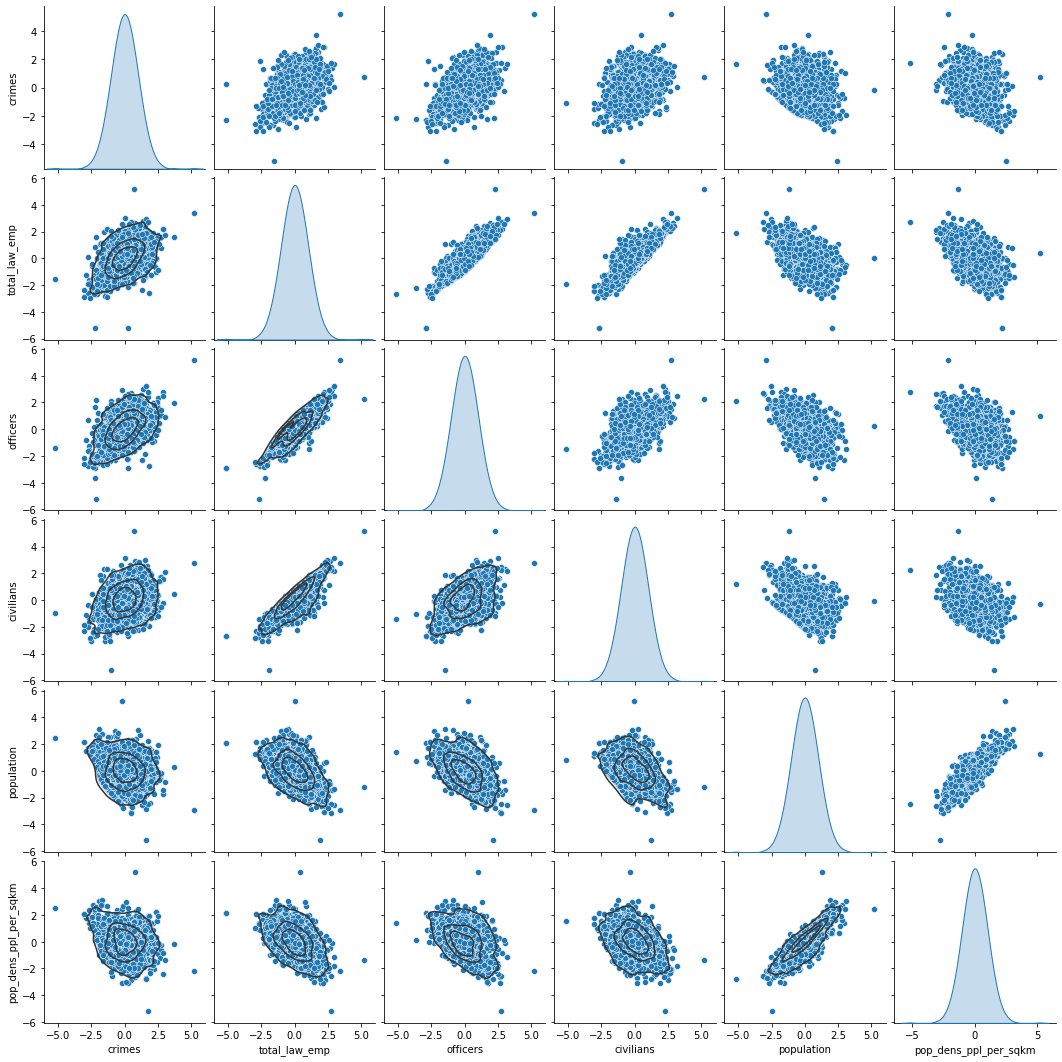

In [37]:
sns.pairplot(scaled_df[skewed_columns], 
             diag_kind='kde').map_lower(sns.kdeplot, levels=4, color='.2')

Select QuantileTransformer as the scaler

### Create input and target 

In [38]:
y = scaled_df['crimes']
X = scaled_df.drop('crimes', axis=1)

In [39]:
print(y.skew())
print(X.skew())

0.009987423257466477
total_law_emp                       -0.049568
officers                            -0.005842
civilians                           -0.003140
percent_edu_less_than_high_school   -0.004471
percent_edu_high_school              0.000657
percent_edu_some_college             0.000349
percent_edu_bachelor_or_higher       0.000273
unemployment_rate                    0.002214
median_HH_Income                     0.000099
population                          -0.000681
pop_dens_ppl_per_sqkm               -0.000706
percent_poverty_all_age             -0.000568
percent_poverty_age_0-17             0.000121
percent_poverty_age_5-17             0.003576
dtype: float64


### Build pipeline to preprocess the data

In [40]:
from sklearn import set_config

set_config(display="diagram")

In [42]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

[]

In [43]:
num_selector(X)

['total_law_emp',
 'officers',
 'civilians',
 'percent_edu_less_than_high_school',
 'percent_edu_high_school',
 'percent_edu_some_college',
 'percent_edu_bachelor_or_higher',
 'unemployment_rate',
 'median_HH_Income',
 'population',
 'pop_dens_ppl_per_sqkm',
 'percent_poverty_all_age',
 'percent_poverty_age_0-17',
 'percent_poverty_age_5-17']

In [44]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
#     PowerTransformer(method="yeo-johnson"), SimpleImputer(strategy="mean", add_indicator=True)
#     QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal'), 
#     SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(with_mean=False), SimpleImputer(strategy="mean", add_indicator=True)
    SimpleImputer(strategy="mean", add_indicator=True) # no need for scaler since already scaled
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])

In [46]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])),
                ('lassocv', LassoCV())])

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [48]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [49]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.com...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50A08>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A9C6C50F48>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

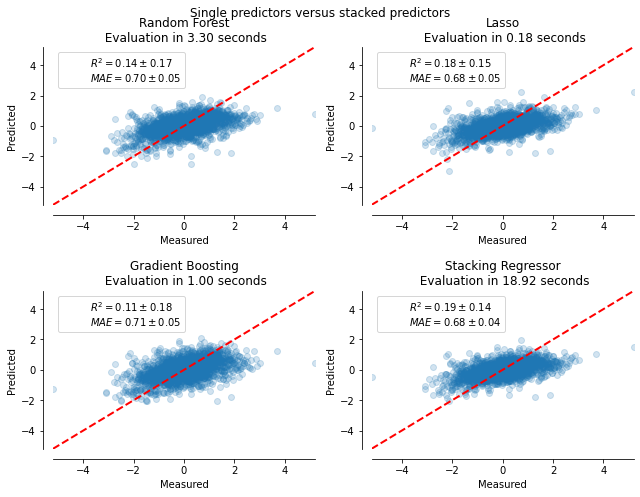

In [50]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### None of the above linear or tree models achieved acceptable accuracy.
### Try unsupervised machine learning to identify clusters and improve accuracy

In [51]:
scaled_df

crimes  total_law_emp  officers  civilians  \
0     0.304320      -0.315197 -0.628796   0.054051   
1     0.060386      -0.145086 -0.723838   0.382935   
2    -1.383505      -1.719436 -1.220762  -1.966160   
3    -1.275232      -1.606415 -1.040565  -1.980003   
4     0.371318      -0.745462 -0.464690  -0.534741   
...        ...            ...       ...        ...   
1804 -1.105864       0.365815 -0.336185   0.880926   
1805  0.313903       2.599360  2.437321   2.401319   
1806 -0.329565       0.587355  0.150194   0.922722   
1807 -1.589092       0.711474  1.148238  -0.052918   
1808 -0.389620      -0.532414  0.344667  -1.130788   

      percent_edu_less_than_high_school  percent_edu_high_school  \
0                             -0.002141                -0.129402   
1                             -0.455707                -0.892383   
2                              1.288444                 1.714694   
3                              0.628080                -0.221138   
4                              0.509197                 0.502410   
...                                 ...                      ...   
1804                          -1.932294                -1.136347   
1805                          -2.326794                 0.008816   
1806                          -1.011885                -0.186998   
1807                          -0.997718                 1.101783   
1808                          -0.220419                -0.640443   

      percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                    -0.537930                        0.674112   
1                     0.051296                        1.053658   
2                    -1.491168                       -1.806162   
3                     0.411655                       -0.215720   
4                    -0.373605                       -0.272898   
...                        ...                             ...   
1804                  1.519902                        0.976814   
1805                  1.476768                        0.334958   
1806                  1.231994                        0.298458   
1807                  0.798737                       -0.614517   
1808                  1.098063                        0.412863   

      unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0             -0.193143          0.302907    0.500739               0.521895   
1             -0.021329          0.447053    1.232105               0.731321   
2              0.205941         -0.564006   -0.199843              -0.180200   
3              0.618059         -0.584945    0.925858               0.942182   
4              0.800496         -0.699103    0.486257               0.515367   
...                 ...               ...         ...                    ...   
1804          -0.193143          0.750674    0.041892              -0.941711   
1805           0.278302          1.422286   -0.949006              -1.942907   
1806           0.340163          1.546022    0.342076              -1.465973   
1807           0.340163          1.139861   -0.273645              -1.028747   
1808          -0.105580          0.065620   -1.149881              -1.556409   

      percent_poverty_all_age  percent_poverty_age_0-17  \
0                   -0.230353                 -0.324254   
1                   -0.695908                 -0.641002   
2                    1.157061                  0.848075   
3                    0.705530                  0.718462   
4                    0.257495                  0.139710   
...                       ...                       ...   
1804                -1.189522                 -1.236652   
1805                -1.497997                 -1.597698   
1806                -1.231280                 -1.220640   
1807                -1.189522                 -1.310017   
1808                -0.468203                 -0.565738   

      percent_poverty_age_5-17  
0                    -0.370902  
1            

In [52]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

4 clusters

In [53]:
n_cluster = 4

In [54]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [55]:
clusters_df = get_clusters(n_cluster, scaled_df)
clusters_df.head()

crimes  total_law_emp  officers  civilians  \
0  0.304320      -0.315197 -0.628796   0.054051   
1  0.060386      -0.145086 -0.723838   0.382935   
2 -1.383505      -1.719436 -1.220762  -1.966160   
3 -1.275232      -1.606415 -1.040565  -1.980003   
4  0.371318      -0.745462 -0.464690  -0.534741   

   percent_edu_less_than_high_school  percent_edu_high_school  \
0                          -0.002141                -0.129402   
1                          -0.455707                -0.892383   
2                           1.288444                 1.714694   
3                           0.628080                -0.221138   
4                           0.509197                 0.502410   

   percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                 -0.537930                        0.674112   
1                  0.051296                        1.053658   
2                 -1.491168                       -1.806162   
3                  0.411655                       -0.215720   
4                 -0.373605                       -0.272898   

   unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0          -0.193143          0.302907    0.500739               0.521895   
1          -0.021329          0.447053    1.232105               0.731321   
2           0.205941         -0.564006   -0.199843              -0.180200   
3           0.618059         -0.584945    0.925858               0.942182   
4           0.800496         -0.699103    0.486257               0.515367   

   percent_poverty_all_age  percent_poverty_age_0-17  \
0                -0.230353                 -0.324254   
1                -0.695908                 -0.641002   
2                 1.157061                  0.848075   
3                 0.705530                  0.718462   
4                 0.257495                  0.139710   

   percent_poverty_age_5-17 class  
0                 -0.370902     1  
1                 -0.503497     2  
2                  0.928105     1  
3                  0.668987     1  
4                  0.196979     1

In [56]:
clusters_df.groupby(by='class').count()

crimes  total_law_emp  officers  civilians  \
class                                               
0         428            428       428        428   
1         524            524       524        524   
2         390            390       390        390   
3         467            467       467        467   

       percent_edu_less_than_high_school  percent_edu_high_school  \
class                                                               
0                                    428                      428   
1                                    524                      524   
2                                    390                      390   
3                                    467                      467   

       percent_edu_some_college  percent_edu_bachelor_or_higher  \
class                                                             
0                           428                             428   
1                           524                             524   
2                           390                             390   
3                           467                             467   

       unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
class                                                                           
0                    428               428         428                    428   
1                    524               524         524                    524   
2                    390               390         390                    390   
3                    467               467         467                    467   

       percent_poverty_all_age  percent_poverty_age_0-17  \
class                                                      
0                          428                       428   
1                          524                       524   
2                          390                       390   
3                          467                       467   

       percent_poverty_age_5-17  
class                            
0                           428  
1                           524  
2                           390  
3                           467

In [57]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

Cluster 1 appears to be an outlier

In [409]:
n_cluster = 4

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



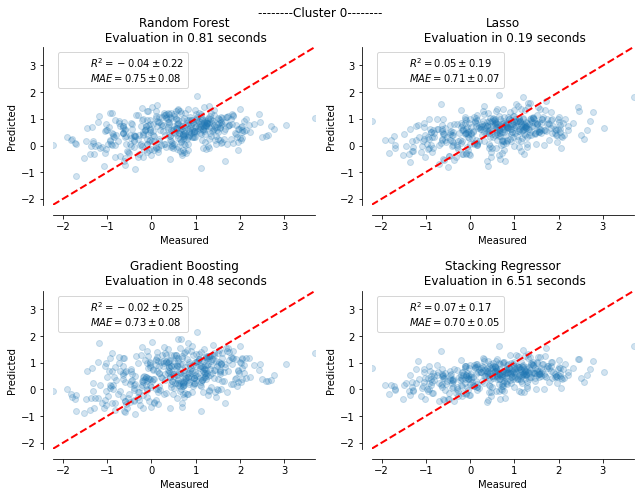

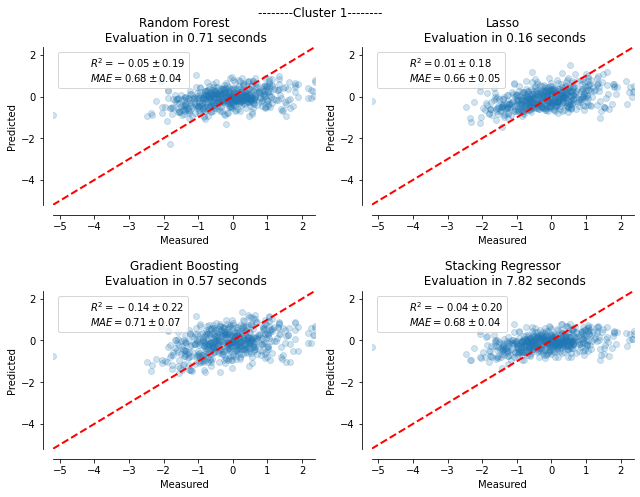

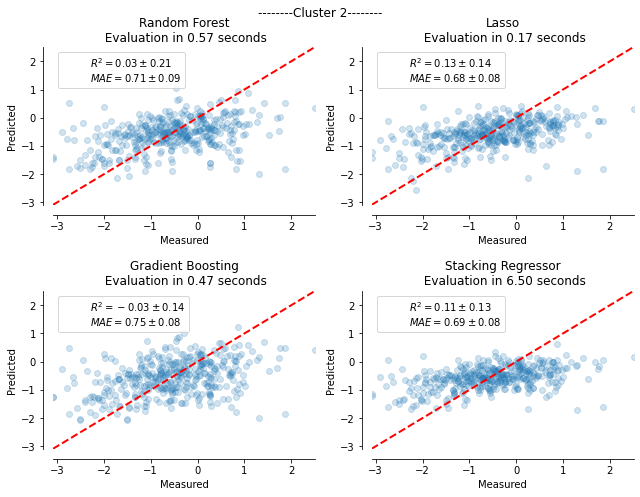

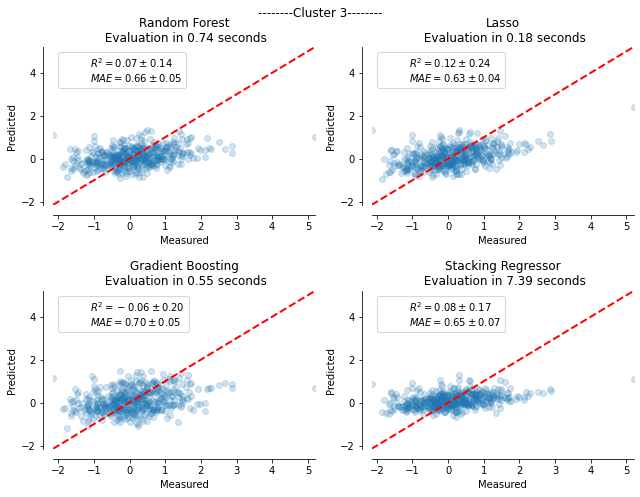

In [58]:
for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

### Examine the distribution of "Crimes" data

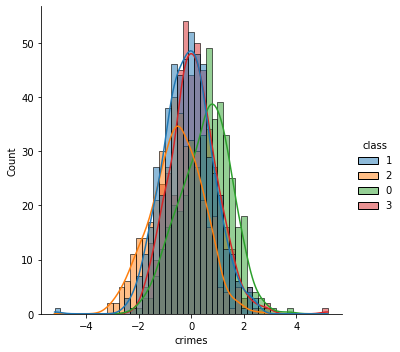

In [59]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
            hue='class',
#             log_scale=True,
            kde=True
            )

### Try NN model

In [60]:
cluster_no = 0

In [61]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


nn_y = cluster_subset_df['crimes']
nn_X = cluster_subset_df.drop('crimes', axis=1)

X_train, X_test, y_train, y_test = train_test_split(nn_X, nn_y)

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 3)                 45        
                                                                 
 dense_24 (Dense)            (None, 2)                 8         
                                                                 
 dense_25 (Dense)            (None, 1)                 3         
                                                                 
 dense_26 (Dense)            (None, 1)                 2         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
None
0.16075588372859084


Text(0, 0.5, 'Predicted')

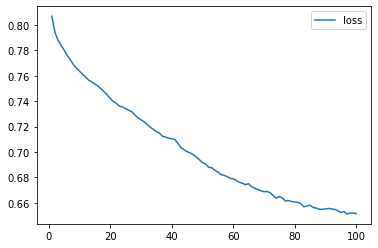

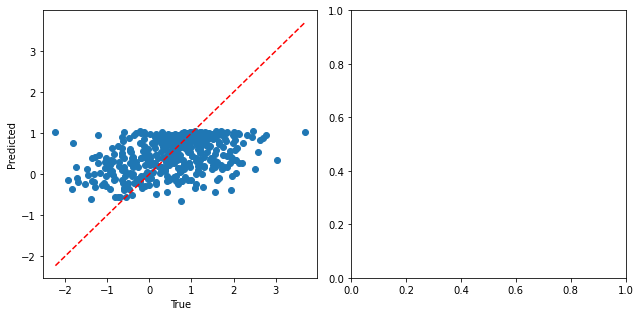

In [71]:
units_input = 3
units_h1 = 2
units_h2 = 1
units_h3 = 0
activation_input = 'tanh'
activation_h1 = 'tanh'
activation_h2 = 'tanh'
activation_h3 = 'LeakyReLU'
activation_output = 'linear'
epochs = 100


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units_input, activation=activation_input, input_dim=nn_X.shape[1]))
if units_h1 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h1, activation=activation_h1))
if units_h2 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h2, activation=activation_h2))
if units_h3 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h3, activation=activation_h3))
nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_output))

# Check the structure of the Sequential model
print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["r_square"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

# compare results
result = pd.DataFrame()
result['True'] = nn_y
result['Predicted'] = nn_model.predict(nn_X)

print(r2_score(result['True'],result['Predicted']))

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(result['True'],result['Predicted'])
ax1.plot([min(result['True']), max(result['True'])], [min(result['True']), max(result['True'])], '--r')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
# ax2.scatter(result['True'], result['Predicted'])
# ax2.plot([0, 0.2], [0, 0.2], 'r')
# ax2.set_xlim(0, 0.25)
# ax2.set_ylim(0, 0.25)
# ax2.set_xlabel('True')
# ax2.set_title('Zoom into Diagnol')

In [415]:
r2_score(result['True'],result['Predicted'])

0.3739827010197442

### dimentionality reduction

In [72]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

In [73]:
scaled_df.head()

crimes  total_law_emp  officers  civilians  \
0  0.304320      -0.315197 -0.628796   0.054051   
1  0.060386      -0.145086 -0.723838   0.382935   
2 -1.383505      -1.719436 -1.220762  -1.966160   
3 -1.275232      -1.606415 -1.040565  -1.980003   
4  0.371318      -0.745462 -0.464690  -0.534741   

   percent_edu_less_than_high_school  percent_edu_high_school  \
0                          -0.002141                -0.129402   
1                          -0.455707                -0.892383   
2                           1.288444                 1.714694   
3                           0.628080                -0.221138   
4                           0.509197                 0.502410   

   percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                 -0.537930                        0.674112   
1                  0.051296                        1.053658   
2                 -1.491168                       -1.806162   
3                  0.411655                       -0.215720   
4                 -0.373605                       -0.272898   

   unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0          -0.193143          0.302907    0.500739               0.521895   
1          -0.021329          0.447053    1.232105               0.731321   
2           0.205941         -0.564006   -0.199843              -0.180200   
3           0.618059         -0.584945    0.925858               0.942182   
4           0.800496         -0.699103    0.486257               0.515367   

   percent_poverty_all_age  percent_poverty_age_0-17  percent_poverty_age_5-17  
0                -0.230353                 -0.324254                 -0.370902  
1                -0.695908                 -0.641002                 -0.503497  
2                 1.157061                  0.848075                  0.928105  
3                 0.705530                  0.718462                  0.668987  
4                 0.257495                  0.139710                  0.196979

In [74]:
sum_explained_variance_ratio = []

for i in range(scaled_df.shape[1]):
    # Initialize PCA model
    pca = PCA(n_components=i)

    # Get i principal components 
    df_pca = pca.fit_transform(scaled_df)

    pca_df = pd.DataFrame(
        data=df_pca, #columns=['pc1','pc2','pc3','pc4']
    )

    sum_explained_variance_ratio.append(sum(pca.explained_variance_ratio_))

In [75]:
sum_explained_variance_ratio

[0,
 0.4086228661010457,
 0.6282057017698011,
 0.721268589816798,
 0.792003843964024,
 0.8437316238868989,
 0.8856848692368423,
 0.9208903230118062,
 0.951377113757459,
 0.9743374011309375,
 0.9826632311136156,
 0.9902157091971487,
 0.9949051412410637,
 0.9982184306212054,
 0.9993518608223969]

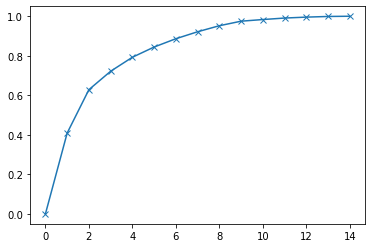

In [76]:
plt.plot(range(scaled_df.shape[1]), sum_explained_variance_ratio, marker='x')

Number of PCs is selected to be 6

In [78]:
pca = PCA(n_components=6)

# Get i principal components 
df_pca = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(
    data=df_pca, #columns=['pc1','pc2','pc3','pc4']
)

In [81]:
pca_df.head()

0         1         2         3         4         5
0  0.967890 -0.561164  0.532789 -0.411093  0.072861  0.049738
1  2.012712 -0.418994  1.001784  0.358432  0.285478 -0.442843
2 -2.137957 -3.338193 -2.131482 -1.543048 -0.207481  0.214785
3 -0.109873 -3.334829 -0.701902  0.934244  0.022493  0.145928
4 -0.682827 -1.517522  0.204348 -0.098855 -0.713140 -0.045859

In [82]:
# Find the best value for K
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [83]:
# Initialize the K-means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
pca_df["class"] = model.labels_
pca_df.head()

0         1         2         3         4         5  class
0  0.967890 -0.561164  0.532789 -0.411093  0.072861  0.049738      3
1  2.012712 -0.418994  1.001784  0.358432  0.285478 -0.442843      0
2 -2.137957 -3.338193 -2.131482 -1.543048 -0.207481  0.214785      3
3 -0.109873 -3.334829 -0.701902  0.934244  0.022493  0.145928      3
4 -0.682827 -1.517522  0.204348 -0.098855 -0.713140 -0.045859      3

In [84]:
pca_df.hvplot.scatter(
    x="0",
    y="1",
    hover_cols=["class"],
    by="class",
)

:NdOverlay   [class]
   :Scatter   [0]   (1,class)

In [85]:
# Plotting the clusters with three features
fig = px.scatter_3d(pca_df, 
                    x=0, 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y=1, 
                    z=2, 
                    color="class", 
                    symbol="class",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [86]:
pca_df.groupby(by='class').count()

0    1    2    3    4    5
class                              
0      388  388  388  388  388  388
1      428  428  428  428  428  428
2      466  466  466  466  466  466
3      527  527  527  527  527  527

In [87]:
scaled_classified_df = scaled_df.reset_index().copy()
scaled_classified_df['class'] = pca_df['class']
scaled_classified_df

index    crimes  total_law_emp  officers  civilians  \
0         0  0.304320      -0.315197 -0.628796   0.054051   
1         1  0.060386      -0.145086 -0.723838   0.382935   
2         2 -1.383505      -1.719436 -1.220762  -1.966160   
3         3 -1.275232      -1.606415 -1.040565  -1.980003   
4         4  0.371318      -0.745462 -0.464690  -0.534741   
...     ...       ...            ...       ...        ...   
1804   1804 -1.105864       0.365815 -0.336185   0.880926   
1805   1805  0.313903       2.599360  2.437321   2.401319   
1806   1806 -0.329565       0.587355  0.150194   0.922722   
1807   1807 -1.589092       0.711474  1.148238  -0.052918   
1808   1808 -0.389620      -0.532414  0.344667  -1.130788   

      percent_edu_less_than_high_school  percent_edu_high_school  \
0                             -0.002141                -0.129402   
1                             -0.455707                -0.892383   
2                              1.288444                 1.714694   
3                              0.628080                -0.221138   
4                              0.509197                 0.502410   
...                                 ...                      ...   
1804                          -1.932294                -1.136347   
1805                          -2.326794                 0.008816   
1806                          -1.011885                -0.186998   
1807                          -0.997718                 1.101783   
1808                          -0.220419                -0.640443   

      percent_edu_some_college  percent_edu_bachelor_or_higher  \
0                    -0.537930                        0.674112   
1                     0.051296                        1.053658   
2                    -1.491168                       -1.806162   
3                     0.411655                       -0.215720   
4                    -0.373605                       -0.272898   
...                        ...                             ...   
1804                  1.519902                        0.976814   
1805                  1.476768                        0.334958   
1806                  1.231994                        0.298458   
1807                  0.798737                       -0.614517   
1808                  1.098063                        0.412863   

      unemployment_rate  median_HH_Income  population  pop_dens_ppl_per_sqkm  \
0             -0.193143          0.302907    0.500739               0.521895   
1             -0.021329          0.447053    1.232105               0.731321   
2              0.205941         -0.564006   -0.199843              -0.180200   
3              0.618059         -0.584945    0.925858               0.942182   
4              0.800496         -0.699103    0.486257               0.515367   
...                 ...               ...         ...                    ...   
1804          -0.193143          0.750674    0.041892              -0.941711   
1805           0.278302          1.422286   -0.949006              -1.942907   
1806           0.340163          1.546022    0.342076              -1.465973   
1807           0.340163          1.139861   -0.273645              -1.028747   
1808          -0.105580          0.065620   -1.149881              -1.556409   

      percent_poverty_all_age  percent_poverty_age_0-17  \
0                   -0.230353                 -0.324254   
1                   -0.695908                 -0.641002   
2                    1.157061                  0.848075   
3                    0.705530                  0.718462   
4                    0.257495                  0.139710   
...                       ...                       ...   
1804                -1.189522                 -1.236652   
1805                -1.497997                 -1.597698   
1806                -1.231280                 -1.220640   
1807                -1.189522                 -1.310017   
1808                -0.468203                 -0.5657

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



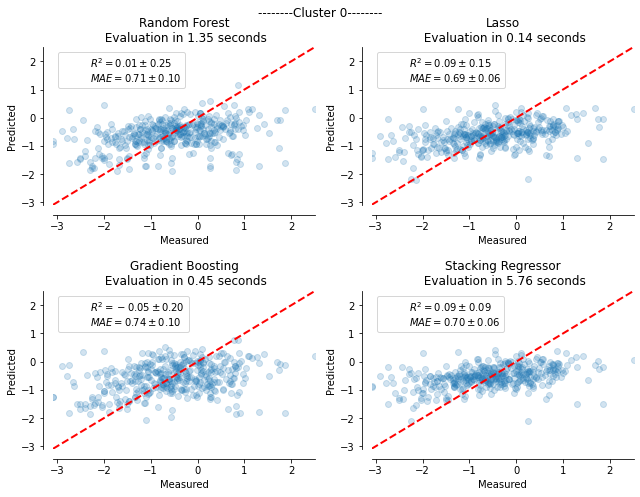

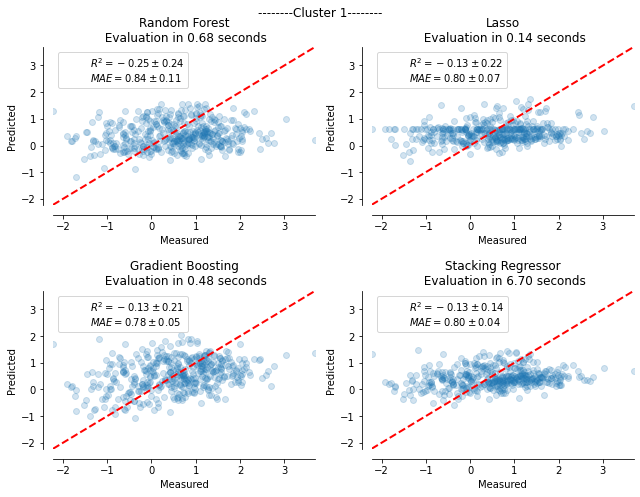

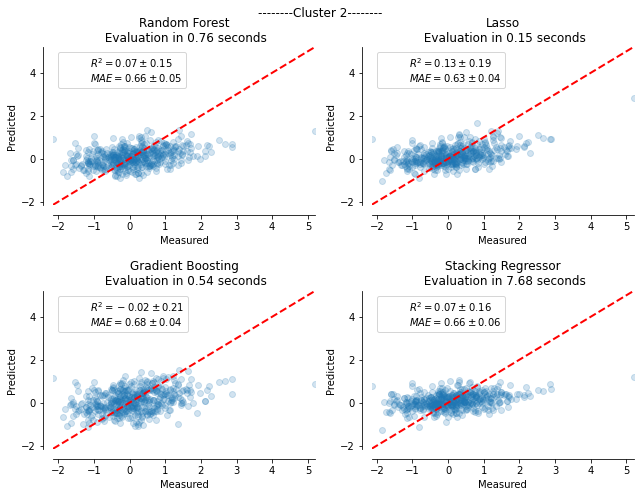

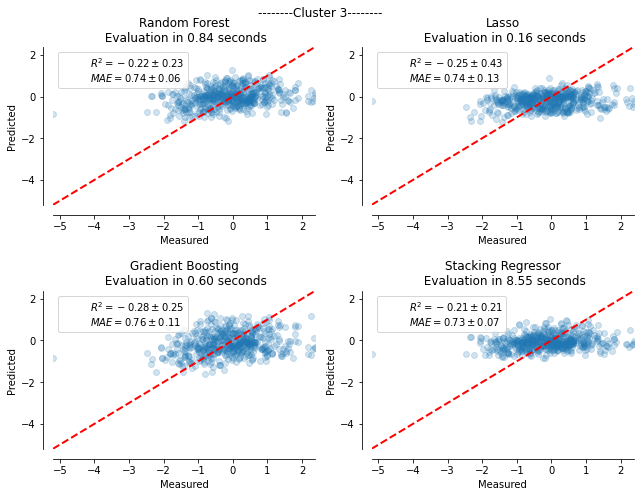

In [88]:
n_cluster = 4

for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = scaled_classified_df[scaled_classified_df['class']==cluster_no]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()